## NLP: Predicting Useful Votes to Healthcare Reviews



In [4]:
import os
import codecs

data_directory = os.path.join('C:/Users/andre/Documents/', 'yelp_dataset_challenge_round9')
businesses_filepath = os.path.join(data_directory, 'yelp_academic_dataset_business.json')
review_json_filepath = os.path.join(data_directory, 'yelp_academic_dataset_review.json')
intermediate_directory = os.path.join(data_directory, 'intermediate')
review_txt_filepath = os.path.join(intermediate_directory, 'review_text_all.txt')

In [3]:
import json
import numpy as np

healthcare_ids = []

# open the businesses file
with codecs.open(businesses_filepath, encoding='utf_8') as f:
    
    # iterate through each line (json record) in the file
    for business_json in f:
        
        # convert the json record to a Python dict
        business = json.loads(business_json)
        
        # if this business has no categories or is not a target entity, skip to the next one
        if business[u'categories'] is None or u'Health & Medical' not in business[u'categories']:
            continue
        # Remove businesses in BW, Germany
        if u'BW' in business[u'state']:
            continue
        # Remove businesses that are restaurants, food and pets
        if u'Restaurants' in business[u'categories'] or u'Food' in business[u'categories'] or 'Pets' in business[u'categories']:
            continue
            
        # add the business id to our healthcare_ids set
        healthcare_ids.append(business[u'business_id'])

# Turn the list of ids into a set, which is faster for testing whether an element is in the set
healthcare_ids = set(healthcare_ids)

# print the number of unique ids in the dataset
print ('{:,}'.format(len(healthcare_ids)), u'health & medical entities in the dataset.')

10,211 health & medical entities in the dataset.


In [5]:
# Create a new file that contains only the text from reviews about healthcare entities.
# One review per line in the this new file.
    
review_count = 0
useful = []
stars = []

# create & open a new file in write mode
with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:

    # open the existing review json file
    with codecs.open(review_json_filepath, encoding='utf_8') as review_json_file:

        # loop through all reviews in the existing file and convert to dict
        for review_json in review_json_file:
            review = json.loads(review_json)

            # if this review is not in the target set, skip to the next one
            if review[u'business_id'] not in healthcare_ids:
                continue

            # write each review as a line in the new file
            # escape newline characters in the original review text
            if review[u'text'] is None:
                print(review_count)
            
            review_txt_file.write(review[u'text'].replace('\n', '\\n').replace('\r','') + '\n')
            review_count += 1
            useful.append(review[u'useful'])
            stars.append(review[u'stars'])

print (u'Text from {:,} healthcare reviews written to the new txt file.'.format(review_count))

Text from 114,556 healthcare reviews written to the new txt file.


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
trigram_sentences_filepath = os.path.join(intermediate_directory, 'trigram_sentences_all.txt')
trigram_reviews_filepath = os.path.join(intermediate_directory, 'trigram_transformed_reviews_all.txt')

In [11]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [12]:
from gensim.models import Word2Vec
word2vec_filepath = os.path.join(intermediate_directory, 'word2vec_model_all')

In [14]:
word2vec = Word2Vec.load(word2vec_filepath)
print(u'{:,} terms in the word2vec vocabulary.'.format(len(word2vec.wv.vocab)))

11,242 terms in the word2vec vocabulary.


In [15]:
# build a list of terms, index, and term counts from the word2vec model
ordered_vocab = [(term, vocab.index, vocab.count) for term, vocab in word2vec.wv.vocab.items()]
ordered_vocab = sorted(ordered_vocab, key=lambda ordered_vocab:ordered_vocab[2], reverse=True)
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

In [16]:
# Creat a dictionary mapping each word to a 100-dimensional vector
word_vectors = dict(list(zip(word2vec.wv.index2word, word2vec.wv.syn0)))

In [17]:
word2vec.most_similar(positive=['dentist'], topn=10)

[('pediatric_dentist', 0.7467591166496277),
 ('dermatologist', 0.7371746897697449),
 ('orthodontist', 0.7342847585678101),
 ('pediatrician', 0.7135860919952393),
 ('chiropractor', 0.6888620853424072),
 ('doctor', 0.673794150352478),
 ('gyno', 0.658856987953186),
 ('obgyn', 0.6247615814208984),
 ('dental', 0.6233406066894531),
 ('gynecologist', 0.6195130348205566)]

In [18]:
word2vec.most_similar(positive=['pediatrician', 'tooth'], negative=['children'],topn=5)

[('dentist', 0.6435350179672241),
 ('filling', 0.5907669067382812),
 ('crown', 0.5610827803611755),
 ('cavity', 0.5536832809448242),
 ('root_canal', 0.5522149801254272)]

In [19]:
word2vec.similarity('pediatrician','dentist')

0.7135860665949898

In [20]:
word2vec.similarity('midwife','dentist')

0.24429898831767718

In [107]:
useful = np.array(useful)
luseful = np.log(useful+1)

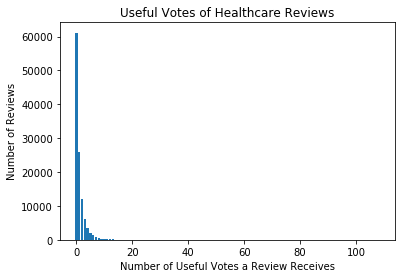

In [429]:
unique, counts = np.unique(useful, return_counts = True)
plt.bar(unique,counts)
plt.xlabel('Number of Useful Votes a Review Receives')
plt.ylabel('Number of Reviews')
plt.title('Useful Votes of Healthcare Reviews')
plt.show()

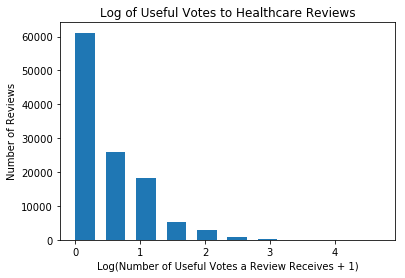

In [432]:
plt.hist(luseful, bins = 10, width = 0.3, align='mid')
plt.xlabel('Log(Number of Useful Votes a Review Receives + 1)')
plt.ylabel('Number of Reviews')
plt.title('Log of Useful Votes to Healthcare Reviews')
plt.show()

In [22]:
X = []
with codecs.open(trigram_reviews_filepath, encoding='utf-8') as f:
    for review in f:
        X.append(review)

In [339]:
class MeanEmbeddingVectorizer():
    """ Given a word to vector mapping, vectorize texts 
    by taking the mean of all the word vectors for each document"""
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in review if w in self.word2vec] 
                   or [np.zeros(self.dim)], axis=0) 
                   for review in X
        ])  

In [437]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from collections import defaultdict

In [407]:
class TfidfMeanVectorizer():
    """ Weight average word fectors by its tf-idf"""
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(list(word2vec.values())[0])
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x:x)
        tfidf.fit(X)
        # Let an unseem word be as infrequent as the most infreqeunt word
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] * self.word2weight[w]
                                 for w in review if w in self.word2vec] or 
                                [np.zeros(self.dim)], axis=0) 
                         for review in X])   

In [115]:
def RMSE(model, X, y):
    """ Root Mean Squared Error"""
    model.fit(X, y)
    return np.sqrt(np.mean((model.predict(X) - y)**2))

def RMSLE(model, X, y):
    """ Root Mean Squared Logarithmic Error"""
    model.fit(X, y)
    return np.sqrt(np.mean(((np.log(model.predict(X) + 1) - np.log(y + 1))**2)))

In [438]:
lr_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)), 
                   ("lr", LinearRegression())])
lr_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                        ("lr", LinearRegression())])
gbr_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)),
                    ("gbr", GradientBoostingRegressor(n_estimators=200))])
gbr_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                    ("gbr", GradientBoostingRegressor(n_estimators=200))])
etr_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)),
                    ("gbr", ExtraTreesRegressor(n_estimators=200))])
etr_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                    ("gbr", ExtraTreesRegressor(n_estimators=200))])
rfr_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)),
                    ("gbr", RandomForestRegressor(n_estimators=200))])
rfr_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                    ("gbr", RandomForestRegressor(n_estimators=200))])

In [441]:
from tabulate import tabulate

all_models = [("lr_w2v", lr_w2v), ("lr_w2v_tfidf", lr_w2v_tfidf),
              ("gbr_w2v", gbr_w2v), ("gbr_w2v_tfidf", gbr_w2v_tfidf),
              ("etr_w2v", lr_w2v), ("etr_w2v_tfidf", lr_w2v_tfidf)]

scores = sorted([(name, cross_val_score(model, X, luseful, cv=3, scoring=RMSE).mean()) 
                 for name, model in all_models], key=lambda x:x[1])

print (tabulate(scores, floatfmt=".4f", headers=("model","score")))

model            score
-------------  -------
lr_w2v          0.5896
etr_w2v         0.5896
lr_w2v_tfidf    0.5894
etr_w2v_tfidf   0.5894
gbr_w2v         0.5850
gbr_w2v_tfidf   0.5838


In [442]:
X_w2v = MeanEmbeddingVectorizer(word_vectors).fit(X, luseful).transform(X)
X_w2v_tfidf = TfidfMeanVectorizer(word_vectors).fit(X, luseful).transform(X)

In [443]:
lr = LinearRegression()
gbr = GradientBoostingRegressor(n_estimators=200)
etr = ExtraTreesRegressor(n_estimators=200)
rfr = RandomForestRegressor(n_estimators=200)

In [444]:
models = [("lr", lr), ("gbr", gbr), ("etr", etr)]

scores_w2v = [(name + "_w2v", cross_val_score(model, X_w2v, luseful, cv=3, scoring=RMSE).mean()) 
                 for name, model in models]
scores_w2v_tfidf = [(name + "_w2v_tfidf", cross_val_score(model, X_w2v_tfidf, luseful, cv=3, scoring=RMSE).mean()) 
                 for name, model in models]

scores = sorted(scores_w2v + scores_w2v_tfidf, key=lambda x:x[1])

print (tabulate(scores, floatfmt=".4f", headers=("model","score")))

model            score
-------------  -------
etr_w2v         0.0096
etr_w2v_tfidf   0.0096
gbr_w2v_tfidf   0.5839
gbr_w2v         0.5850
lr_w2v          0.5895
lr_w2v_tfidf    0.5898


In [451]:
lr.fit(X_w2v, luseful)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [484]:
# Find the predicted usefulness of each word
words = np.array(list(word_vectors.keys()))
predicted = lr.predict(list(word_vectors.values()))
indices = np.argsort(predicted)

In [557]:
useful_words = words[indices[-10:]]
useful_pred = predicted[indices[-10:]]

print ("Most Useful Words      Predicted Useful Votes")
for w, p  in zip(reversed(useful_words), reversed(useful_pred)):
    print("{:>17}       {:1.2f}".format(w,p))

Most Useful Words      Predicted Useful Votes
             skin       2346209.92
              eye       2320427.88
           tattoo       2167487.04
            earth       2132636.61
             hair       2082474.62
        procedure       2055094.12
            tooth       2006367.27
          further       1889233.37
             seem       1857850.94
             baby       1799386.17


In [532]:
useless_words = words[indices[:10]]
useless_pred = predicted[indices[:10]]

print ("Least Useful Words      Predicted Useful Votes")
for w, p  in zip(useless_words, useless_pred):
    print("{:>17}       {:1.2f}".format(w,p))

Least Useful Words      Predicted Useful Votes
             same       -2178731.56
         pressure       -2022081.84
             next       -1950813.56
             past       -1932065.84
             call       -1745050.74
     prescription       -1728042.56
             pain       -1663079.25
               ne       -1611270.87
              due       -1553842.38
              fit       -1528422.57


In [591]:
pred_useful = lr.predict(X_w2v)

In [590]:
means = np.array([np.average(pred_useful, weights= useful==x) for x in unique])

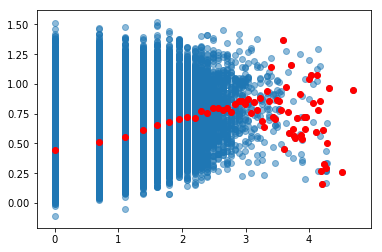

In [588]:
plt.scatter(luseful, pred_useful, alpha=0.5)
plt.scatter(np.log(unique+1), means, color='red')
plt.show()

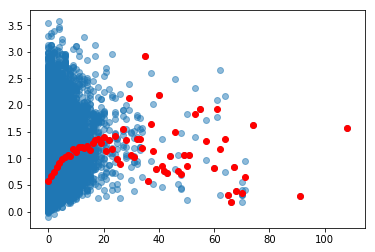

In [589]:
plt.scatter(useful, np.exp(pred_useful)-1, alpha=0.5)
plt.scatter(unique, np.exp(means)-1, color='red')
plt.show()

In [409]:
RMSE(LinearRegression(), Xtfidf, luseful)

0.59084590929567571

In [410]:
RMSE(LinearRegression(), Xt, luseful)

0.59047327127623039

Gradient Boosting 

In [435]:
RMSE(GradientBoostingRegressor(), Xt, luseful)

0.60032942174447346

In [436]:
RMSE(GradientBoostingRegressor(), Xtfidf, luseful)

0.5996071528103476

In [119]:
cross_val_score(lr_w2v, X, luseful, cv=5, scoring=RMSE)

array([ 0.57954947,  0.57838638,  0.59146456,  0.59132053,  0.60234909])

In [524]:
class MaxEmbeddingVectorizer():
    """ Vectorize each document by taking the maximum value of all word vectors"""
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.concatenate([np.array([self.word2vec[w]]) for w in review if w in self.word2vec] 
                or [np.zeros(self.dim)], axis=0).max(axis=0)
            for review in X])

In [525]:
lXt = MaxEmbeddingVectorizer(word_vectors).fit(X, luseful).transform(X)
lXt.shape
# Why the shape is not (114556, 100)?

()

In [ ]:
class MaxMinEmbeddingVectorizer():
    """ Vectorize each document by using both the maximum and minimum values of all word vectors"""
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.append(
            np.concatenate([np.array([self.word2vec[w]]) for w in review if w in self.word2vec]
                or [np.zeros(self.dim)], axis=0).max(axis=0), 
            np.concatenate([np.array([self.word2vec[w]]) for w in review if w in self.word2vec] 
                or [np.zeros(self.dim)], axis=0).min(axis=0))
                         for review in X])